# Predicting Car Prices Using K-Nearest Neighbours
## Overview

###### In this project we will be using the KNN algorithm to predict a car's market value based on its attributes

###### The data set we will be using is found (here)[https://archive.ics.uci.edu/ml/datasets/automobile] and contains a vast array of car information

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt #for graph plotting#
import pandas as pd #for dataframe editing#
import numpy as np #for numeric operations#
from sklearn.neighbors import KNeighborsRegressor #for performing the KNN stats#
from sklearn.metrics import mean_squared_error #to calculate the error between predicted and actual#
import seaborn as sns #for graph plotting#
from sklearn.model_selection import cross_val_score, KFold #for performing K-fold type KNN#
cars = pd.read_csv('imports-85.data')

In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
3              204 non-null int64
?              204 non-null object
alfa-romero    204 non-null object
gas            204 non-null object
std            204 non-null object
two            204 non-null object
convertible    204 non-null object
rwd            204 non-null object
front          204 non-null object
88.60          204 non-null float64
168.80         204 non-null float64
64.10          204 non-null float64
48.80          204 non-null float64
2548           204 non-null int64
dohc           204 non-null object
four           204 non-null object
130            204 non-null int64
mpfi           204 non-null object
3.47           204 non-null object
2.68           204 non-null object
9.00           204 non-null float64
111            204 non-null object
5000           204 non-null object
21             204 non-null int64
27             204 non-null int64
13495          204 n

###### This dataset is complete with no null values. Machine learning will need numeric values for all columns in the training and test data however.

###### Lots of columns names here are seemingly meaningless, the cause of this is the database has no header and has taken the first car row as the header.

###### We can fix this by setting header = None in the read_csv method

In [3]:
cars = pd.read_csv('imports-85.data', header = None)

In [4]:
cars.columns = ['symboling','normalized-losses','make','fuel-type',' aspiration',' num-of-doors',' body-style',' drive-wheels',
' engine-location',' wheel-base',' length',' width',' height',' curb-weight',' engine-type',
' num-of-cylinders',' engine-size',' fuel-system',' bore',' stroke',' compression-ratio',
' horsepower',' peak-rpm',' city-mpg',' highway-mpg',' price']

In [5]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


###### ? is used here in place of a null value, we can convert this to allow better processing

In [6]:
cars = cars.replace('?', np.nan)

In [7]:
cars.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', ' aspiration',
       ' num-of-doors', ' body-style', ' drive-wheels', ' engine-location',
       ' wheel-base', ' length', ' width', ' height', ' curb-weight',
       ' engine-type', ' num-of-cylinders', ' engine-size', ' fuel-system',
       ' bore', ' stroke', ' compression-ratio', ' horsepower', ' peak-rpm',
       ' city-mpg', ' highway-mpg', ' price'],
      dtype='object')

## Selecting The Variables For KNN

###### K Nearest Neighbors works with variables that are continuous, it can also work for ordinal variables but this presents its own difficulty. For now we shall use the continuous variables:

###### These columns contain continuous numeric data: 
> ###### normalised losses - Value decrease over time normalised compared to other
 
> ###### wheel-base - Distance between tyres

> ###### length - Car length

> ###### width - Car width

> ###### height - Car height
 
> ###### curb-weight - Weight of car

> ###### engine-size - Total capacity of the engine cylinders

> ###### bore - Diameter of engine cylinder

> ###### stroke - Number of strokes to complete the five functions of a combustion cylce

> ###### compression-ratio - A ratio of total cylinder volume at highest to lowest

> ###### horsepower - A measure of power (in pounds of force for each foot per minute)

> ###### peak-rpm - Engine spin speed (revolution per minute)

> ###### city-mpg - Estimated miles per gallon for city driving

> ###### highway-mpg - Estimated miles per gallon for highway driving

 
###### Some of these column are numeric but not continuous and may influence the price: 
> ###### symbolling - Showing level of risk in insurance for this car (+3 is high risk, -3 is low risk

> ###### num-of-doors - number of doors

> ###### aspiration - Standard or with a turbocharger

> ###### drive-wheels - 4 wheel drive, front wheel drive or real wheel drive

> ###### engine-location - front or rear

###### Columns that will not be considered:

> ###### engine-type - dohc, dohcv, l, ohc, ohcf, ohcv, rotor. Online literature says there is dispute about how to classify engine types into ordinal (ordered) categories

> ###### fuel-system - 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. As per engine-type this will be difficult to order.

> ###### fuel-type - Diesel or gasoline powered. As per engine-type the dispute continous of the best fuel type.

> ###### num-of-cylinders - currently each are words rather than numeric (i.e four should be 4 for our model). As per engine-type, some prefer certain noises from certain engine types. As for increased power this column is superceeded by the horsepower column

> ###### body-style - Hardtop wagon, sedan, hatchback or convertible. Difficult to order. Most convertible cars are expected to be highprice but many saloon style cars can be vastly more (or less) expensive.

> ###### make - Alfa-romero, audi etc. Very difficult to order.

In [8]:
#removing of spaces before column names#
cars.columns = cars.columns.str.strip()

In [9]:
#for the continuous variables label as cars_cont#
cars_cont = cars.drop(columns=['symboling','make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
        'engine-type','num-of-cylinders','fuel-system'])

In [10]:
cars_cont.columns

Index(['normalized-losses', 'wheel-base', 'length', 'width', 'height',
       'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio',
       'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'],
      dtype='object')

In [11]:
len(cars_cont.columns)

15

We now have 15 columns. 14 features and one target (price).

In [12]:
cars_cont.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
normalized-losses    164 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-size          205 non-null int64
bore                 201 non-null object
stroke               201 non-null object
compression-ratio    205 non-null float64
horsepower           203 non-null object
peak-rpm             203 non-null object
city-mpg             205 non-null int64
highway-mpg          205 non-null int64
price                201 non-null object
dtypes: float64(5), int64(4), object(6)
memory usage: 24.1+ KB


## Data Cleaning

###### Next step is to covert all these columns to int or float.

In [13]:
cars_cont[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']] = cars_cont[['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']].astype(float)

###### Here is a visualisation of the data spread of the price:

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


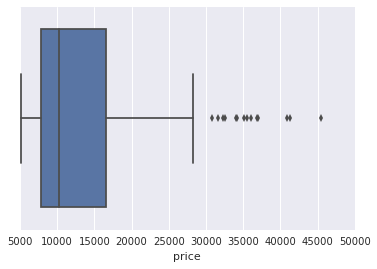

In [14]:
ax1 = sns.boxplot(x = cars_cont['price'])

###### Our model will greatly influenced by variables that have a correlation (positive or negative) with the price. Here are the correlation results:

In [15]:
corr = cars_cont.corr()
corr['price'].sort_values()

highway-mpg         -0.704692
city-mpg            -0.686571
peak-rpm            -0.101649
compression-ratio    0.071107
stroke               0.082310
height               0.135486
normalized-losses    0.203254
bore                 0.543436
wheel-base           0.584642
length               0.690628
width                0.751265
horsepower           0.810533
curb-weight          0.834415
engine-size          0.872335
price                1.000000
Name: price, dtype: float64

###### From this we can expect a car with a large engine size, curb-weigh, horsepower, size (wheel-base, length, width) and cylinder size (bore), with low miles per gallon (highway-mpg, city-mpg) to be very expensive.

###### Its seems sensible that these variables are somewhat linked, a heavier car would also be big in size and have low miles per gallon. Here is a heatmap for information:

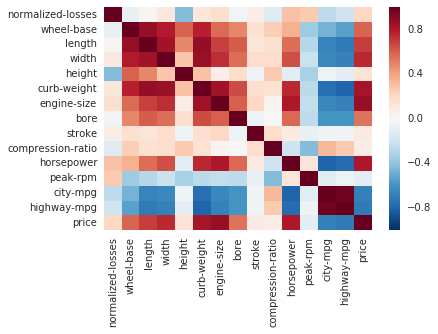

In [16]:
sns.heatmap(corr)

###### It is of interest to note that those with weak correlation to price: 
- ###### peak-rpm, compression-ratio, stroke, height, normalized-losses

###### also have low correlation to every other variable

###### Let us now explore missing values:

In [17]:
print('Number of rows = ', len(cars_cont), '\n')
print('Missing Values for each column:')
print(cars_cont.isnull().sum())

Number of rows =  205 

Missing Values for each column:
normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64


###### Our first problem. Normalized losses has 41 missing rows, if dropped we lose 20% of our data. 

###### Normalized losses very weakly influences the price and altering 20% of the data using an average may negate or exacerbate this influence.

###### We will simply remove the column.

In [18]:
cars_cont = cars_cont.drop(columns=['normalized-losses'])

###### Now lets see all remaining rows with a missing value

In [19]:
a_filter = cars_cont['price'].isnull() | cars_cont['bore'].isnull() | cars_cont['stroke'].isnull() | cars_cont['horsepower'].isnull() | cars_cont['peak-rpm'].isnull()
cars_cont[a_filter]

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
9,99.5,178.2,67.9,52.0,3053,131,3.13,3.40,7.0,160.0,5500.0,16,22,NaN
44,94.5,155.9,63.6,52.0,1874,90,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
45,94.5,155.9,63.6,52.0,1909,90,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
55,95.3,169.0,65.7,49.6,2380,70,NaN,NaN,9.4,101.0,6000.0,17,23,10945.0
56,95.3,169.0,65.7,49.6,2380,70,NaN,NaN,9.4,101.0,6000.0,17,23,11845.0
57,95.3,169.0,65.7,49.6,2385,70,NaN,NaN,9.4,101.0,6000.0,17,23,13645.0
58,95.3,169.0,65.7,49.6,2500,80,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0
129,98.4,175.7,72.3,50.5,3366,203,3.94,3.11,10.0,288.0,5750.0,17,28,NaN
130,96.1,181.5,66.5,55.2,2579,132,3.46,3.90,8.7,NaN,NaN,23,31,9295.0
131,96.1,176.8,66.6,50.5,2460,132,3.46,3.90,8.7,NaN,NaN,23,31,9895.0


###### We only have 10 rows with missing data. The only variable that has little impact is peak-rpm, this would be kept but data for these rows is also missing in the horsepower column. 

###### To prevent an introduction of bias (by using a mean or median) we will remove these rows also.

In [20]:
# ~ Represents perform the inverse of#
cars_cont = cars_cont[~a_filter]

In [21]:
cars_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 14 columns):
wheel-base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb-weight          195 non-null int64
engine-size          195 non-null int64
bore                 195 non-null float64
stroke               195 non-null float64
compression-ratio    195 non-null float64
horsepower           195 non-null float64
peak-rpm             195 non-null float64
city-mpg             195 non-null int64
highway-mpg          195 non-null int64
price                195 non-null float64
dtypes: float64(10), int64(4)
memory usage: 22.9 KB


### Data Normalisation
###### Now are data is purged of missing information we must normalise the data.

###### Below is some boxplots that can help visualise why we need to do this:

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


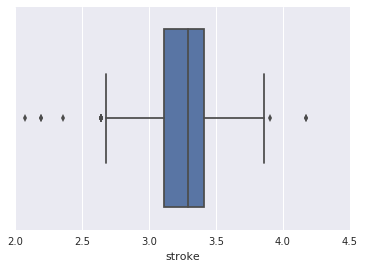

In [22]:
ax1 = sns.boxplot(x = cars_cont['stroke'])

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


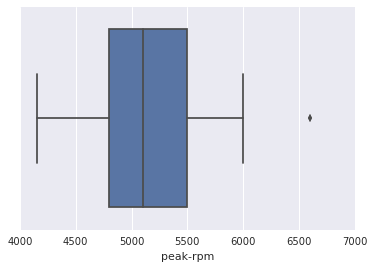

In [23]:
ax2 = sns.boxplot(x = cars_cont['peak-rpm'])

###### The KNN model will work out the mean squared errors from the data.

###### A deviation of 1000 in peak-rpm is not unexpected, as could be a 1 difference in stroke.

###### The issue arises as the 1000 rpm will count many magnitudes of order in influencing the mean squared error and cause poor modelling.

In [24]:
#Normalisation in this context is forming data from a 0 to 1 scale#
#This is done by taking the value V in column C#
#Then new value = (V -C.min) / (C.max - C.min)
cars_cont_norm = (cars_cont - cars_cont.min() ) / (cars_cont.max() - cars_cont.min())

In [25]:
cars_cont_norm.head()

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.207959
1,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,0.282558
2,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,0.282558
3,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,0.219254
4,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,0.306142


## Creating A Univariate KNN Model

###### All values are now normalised, so the next step is creating our machine learning model.

###### The first demonstration is that of a single variable or 'univariate'


###### Data is split into two equal sized portions to form the train & test data. This is called holdout validation

In [26]:
def knn_train_test(training_column_name, target_column_name, dataframe):
    #find midpoint of data#
    data_midpoint = int(len(dataframe)/ 2)
    #randomise data#
    np.random.seed(10)
    shuffle_index = np.random.permutation(dataframe.index)
    df = dataframe.reindex(shuffle_index)
    #split data into 50:50 train and test#
    train = df[:data_midpoint]
    test = df[data_midpoint:]
    knn = KNeighborsRegressor()
    knn.fit(train[[training_column_name]], train[target_column_name])
    predictions = knn.predict(test[[training_column_name]])
    mse = mean_squared_error(test[[target_column_name]], predictions)
    rmse = mse ** 0.5
    return (rmse, training_column_name)

In [27]:
uni_vari_column_results = []
column_names = ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size',
       'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
       'city-mpg', 'highway-mpg']
for i in column_names:
    uni_vari_column_results.append(knn_train_test(i, 'price', cars_cont_norm))
sorted(uni_vari_column_results, reverse = True)

[(0.23951319951959624, 'peak-rpm'),
 (0.20529337510706833, 'height'),
 (0.1924112289171109, 'stroke'),
 (0.1812322381292307, 'bore'),
 (0.1445044561018585, 'compression-ratio'),
 (0.14205111727370864, 'length'),
 (0.138907362392898, 'wheel-base'),
 (0.11513388210435571, 'highway-mpg'),
 (0.10825527634424237, 'width'),
 (0.10398624836252071, 'horsepower'),
 (0.10279219956671605, 'city-mpg'),
 (0.09747328986609792, 'curb-weight'),
 (0.08914233568669673, 'engine-size')]

###### The smallest errors are in engine-size. This list correlates well with are precalculated correlations.

## Creating A Univariate KNN Model With Variable K

###### K by default is set as 5. This means it will take the 5 nearest points to the target into consideration. It is useful to explore a variation of these to explore and minimise bias and variation.

In [28]:
def knn_train_test_vari_k(training_column_name, target_column_name, dataframe, k):
    #find midpoint of data#
    data_midpoint = int(len(dataframe)/ 2)
    #randomise data#
    np.random.seed(10)
    shuffle_index = np.random.permutation(dataframe.index)
    df = dataframe.reindex(shuffle_index)
    #split data into 50:50 train and test#
    train = df[:data_midpoint]
    test = df[data_midpoint:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train[[training_column_name]], train[target_column_name])
    predictions = knn.predict(test[[training_column_name]])
    mse = mean_squared_error(test[[target_column_name]], predictions)
    rmse = mse ** 0.5
    return (training_column_name, rmse, k)

In [29]:
column_results = []
for i in column_names:
    for k in range(1,11):
        column_results.append(knn_train_test_vari_k(i, 'price', cars_cont_norm, k))

In [30]:
df_column_results = pd.DataFrame(column_results, columns = ['feature', 'rmse', 'k_value'])
df_column_results

,feature,rmse,k_value
0,wheel-base,0.109526,1
1,wheel-base,0.122833,2
2,wheel-base,0.129346,3
3,wheel-base,0.132992,4
4,wheel-base,0.138907,5
5,wheel-base,0.136451,6
6,wheel-base,0.141106,7
7,wheel-base,0.140233,8
8,wheel-base,0.139969,9
9,wheel-base,0.138883,10


###### Our list of column results is now complete, next we will collect the data to plot k vs RMSE

###### I have plotted this in two separate graphs to better view the data

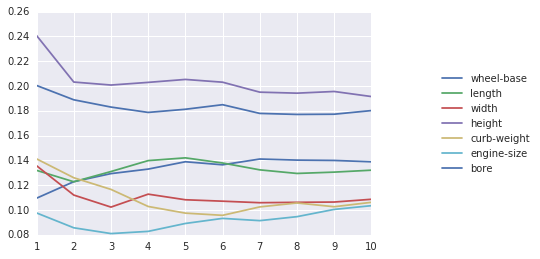

In [31]:
fig, ax = plt.subplots()
plt.plot(df_column_results['k_value'][0:10], df_column_results['rmse'][0:10], label = column_names[0])
plt.plot(df_column_results['k_value'][10:20], df_column_results['rmse'][10:20], label = column_names[1])
plt.plot(df_column_results['k_value'][20:30], df_column_results['rmse'][20:30], label = column_names[2])
plt.plot(df_column_results['k_value'][30:40], df_column_results['rmse'][30:40], label = column_names[3])
plt.plot(df_column_results['k_value'][40:50], df_column_results['rmse'][40:50], label = column_names[4])
plt.plot(df_column_results['k_value'][50:60], df_column_results['rmse'][50:60], label = column_names[5])
plt.plot(df_column_results['k_value'][60:70], df_column_results['rmse'][60:70], label = column_names[6])
plt.figure(figsize = (30,30))
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5))


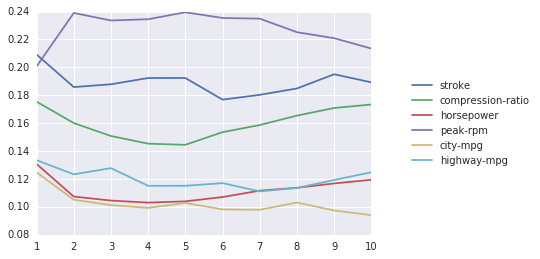

In [32]:
fig, ax = plt.subplots()
plt.plot(df_column_results['k_value'][70:80], df_column_results['rmse'][70:80], label = column_names[7])
plt.plot(df_column_results['k_value'][80:90], df_column_results['rmse'][80:90], label = column_names[8])
plt.plot(df_column_results['k_value'][90:100], df_column_results['rmse'][90:100], label = column_names[9])
plt.plot(df_column_results['k_value'][100:110], df_column_results['rmse'][100:110], label = column_names[10])
plt.plot(df_column_results['k_value'][110:120], df_column_results['rmse'][110:120], label = column_names[11])
plt.plot(df_column_results['k_value'][120:130], df_column_results['rmse'][120:130], label = column_names[12])
plt.figure(figsize = (30,30))
ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5))


###### The graphs are not too easy to decypher. We will now sum up for each k_value to see the overall minima

In [33]:
df_column_results.groupby(by='k_value').mean().sort_values(by='rmse')

,rmse
k_value,
7,0.141605
4,0.141735
6,0.142043
3,0.142309
8,0.142575
5,0.143130
9,0.144102
10,0.144278
2,0.144794


###### Where K = 7 gives the lowest relative means squared error (rmse)

###### The rmse on average was 0.141605, or a 14% error.

## Creating A Multivariate KNN Model
###### We will now proceed with a KNN model that uses all features (variables) to potentially greatly improve the accuracy of our model

In [34]:
def knn_train_test_multi_feature(n_features, training_column_names, target_column_name, dataframe):
    #find midpoint of data#
    data_midpoint = int(len(dataframe)/ 2)
    #randomise data#
    np.random.seed(10)
    shuffle_index = np.random.permutation(dataframe.index)
    df = dataframe.reindex(shuffle_index)
    #split data into 50:50 train and test#
    train = df[:data_midpoint]
    test = df[data_midpoint:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train[training_column_names], train[target_column_name])
    predictions = knn.predict(test[training_column_names])
    mse = mean_squared_error(test[target_column_name], predictions)
    rmse = mse ** 0.5
    return (n_features, rmse)

###### Recall from earlier the columns with the lowest error (seen below)

In [35]:
sorted(uni_vari_column_results)

[(0.08914233568669673, 'engine-size'),
 (0.09747328986609792, 'curb-weight'),
 (0.10279219956671605, 'city-mpg'),
 (0.10398624836252071, 'horsepower'),
 (0.10825527634424237, 'width'),
 (0.11513388210435571, 'highway-mpg'),
 (0.138907362392898, 'wheel-base'),
 (0.14205111727370864, 'length'),
 (0.1445044561018585, 'compression-ratio'),
 (0.1812322381292307, 'bore'),
 (0.1924112289171109, 'stroke'),
 (0.20529337510706833, 'height'),
 (0.23951319951959624, 'peak-rpm')]

In [36]:
#Create a list of the top feature names#
top_feature = [item[1] for item in sorted(uni_vari_column_results)]

###### Next challenge is to see how the number of features influences the rmse. We will work down the list from best to worst. Starting with 1 feature and ending on 13 features

In [37]:
print('number of features, rmse:', '\n')
for i in range(1,14):
    print(knn_train_test_multi_feature(i, top_feature[:i], 'price', cars_cont_norm))

number of features, rmse: 

(1, 0.10348535228042828)
(2, 0.09896697090430945)
(3, 0.08960053896256964)
(4, 0.08976784421671026)
(5, 0.09025179327985412)
(6, 0.09028811570574113)
(7, 0.09566096777171264)
(8, 0.0984030275242053)
(9, 0.10806574307559925)
(10, 0.10882544575990001)
(11, 0.10959831663188566)
(12, 0.10576516477023892)
(13, 0.11004788573307327)


###### Including all of the features actually decreases our accuracy. The best number of features here is 3 and gives a ~9% error. 

###### This is somewhat suprising as where we saw as many as 7 features with high correlation, perhaps this is somewhat reflected in the 3 to 6 features here  which do not significantly increase the error.

## Creating A The Three Variate KNN Model With Variable K
###### The top 3 features of engine-size, curb-weight and city-mpg have been selected as the best variates.

###### Now lets see the best K_number for this new model

In [38]:
def knn_train_test_trivari_k(target_column_name, dataframe, k):
    #find midpoint of data#
    data_midpoint = int(len(dataframe)/ 2)
    #randomise data#
    np.random.seed(10)
    shuffle_index = np.random.permutation(dataframe.index)
    df = dataframe.reindex(shuffle_index)
    #split data into 50:50 train and test#
    train = df[:data_midpoint]
    test = df[data_midpoint:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train[['engine-size', 'curb-weight', 'city-mpg']], train[target_column_name])
    predictions = knn.predict(test[['engine-size', 'curb-weight', 'city-mpg']])
    mse = mean_squared_error(test[[target_column_name]], predictions)
    rmse = mse ** 0.5
    return (rmse, k)

In [39]:
trivari_column_results = []
for k in range(1,26):
    trivari_column_results.append(knn_train_test_trivari_k('price', cars_cont_norm, k))
sorted(trivari_column_results)

[(0.08451578609478995, 1),
 (0.08694630813252058, 11),
 (0.08960053896256964, 10),
 (0.08966588210495126, 14),
 (0.0899296709596606, 9),
 (0.08998625257207737, 8),
 (0.09012811248838966, 13),
 (0.0904875546940634, 12),
 (0.09093281448592609, 7),
 (0.09134329828182572, 15),
 (0.09306681698697236, 16),
 (0.09439765365481351, 5),
 (0.09532547297901982, 17),
 (0.09564605968653893, 6),
 (0.09606175884672191, 18),
 (0.09667343889040163, 3),
 (0.09746177633268838, 19),
 (0.09747195225711154, 4),
 (0.0986969071106188, 20),
 (0.1005900263402369, 21),
 (0.10096025283609317, 2),
 (0.10208622218162756, 22),
 (0.10291747256171033, 23),
 (0.10301240318176466, 24),
 (0.10514241952169709, 25)]

###### It is very interesting to see that a value of 1 for number of neighbours gives the best result. Perhaps this is because there happens to be many car nearly identical in the test and train sets. And introducing a second slightly less close car increases the error.

###### Our error rate has now dropped to 8%. The lowest error seen in a single variable (engine_size) at neighbours = 3 (see the graphs) was also 8%. 

###### Another technique we will now explore is K-Folds Cross Validation

## Creating A The Three Variate KNN Model With Variable K-Fold Cross Validation
###### Earlier we have been using a 50 - 50 split K-Fold Cross Validation. However it can be better to vary this split to 80:20 for instance.

###### A K-Fold Cross Validation split number of 5 will use 20% for the test, but crucially it will move the location of the 20% such that 5tests are run and all data is tested and trained.

###### [If this is difficult to visualise this graphic may explain better](https://s3.amazonaws.com/dq-content/kfold_cross_validation.png)

In [83]:
def knn_train_test_kfold_vari_k(train_columns, target_column, dataframe, k, fold):
    np.random.seed(10)
    shuffle_index = np.random.permutation(dataframe.index)
    df = dataframe.reindex(shuffle_index)
    kf = KFold(n_splits = fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors = k)
    mses = cross_val_score(model, dataframe[train_columns], dataframe[target_column], scoring="neg_mean_squared_error", cv=kf)
    absolutes = np.absolute(mses)
    rmse = absolutes ** 0.5
    mean_rmse = np.mean(rmse)
    return (mean_rmse, fold, k)

In [92]:
folds_rmses = []
for k in range(1,5):
    for fold in range(5,51):
        folds_rmses.append(knn_train_test_kfold_vari_k(['engine-size', 'curb-weight', 'city-mpg'],'price', cars_cont_norm, k, fold))

In [93]:
folds_df = pd.DataFrame(folds_rmses, columns = ['rmse', 'n_of_folds', 'k_value'])

In [95]:
folds_df.sort_values(by='rmse').head()

,rmse,n_of_folds,k_value
85,0.057858,44,2
84,0.058039,43,2
89,0.058233,48,2
88,0.058326,47,2
91,0.058357,50,2


###### Our error rate has now been reduced to just below 6%, for 44 folds with number of neighbours (k_value) of 2.

###### This highlights the complexity of machine learning and the great work needed to even acheive small gains in accuracy.